# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import os
from scipy.io import loadmat
import time
from scipy.interpolate import griddata
from scipy.interpolate import RegularGridInterpolator

In [3]:
# Parameters
tau = 0.02
discount = 0.95
w1, w2, w3 = 0.4, -0.3, -0.7
alpha = 0.5
beta = 0.4
state_dim = 6
action_dim = 9
num_agents = 4
buffer_size = 100000
batch_size = 64
max_episodes = 2000
max_steps = 500
constV = 10 # constant speed
wind_scale_fac = 1.5
Dim = 1550
LowDim = 50
# known target positions
Tpos = np.array([[1430, 1200], [1000, 800], [500, 400], [200, 1500]])

In [6]:
import os, pathlib
print(os.getcwd())


/Users/isaiahthompson/PyCharmMiscProject


In [4]:
# ============================================================================================
# Load the wind data
# ============================================================================================
# the present path
mainfolder = os.getcwd()
# Load wind data from .mat files
def plot_vel_vector(directory=mainfolder+'/OneDrive_1_8-7-2024', frame_range=(7, 7)):
    if not os.path.exists(directory):
        print(f"Directory {directory} not found, using synthetic wind data.")
        x = np.linspace(0, 1600, 20)
        y = np.linspace(0, 1600, 20)
        px, py = np.meshgrid(x, y)
        pvx = np.sin(px / 1600 * 2 * np.pi) * 2
        pvy = np.cos(py / 1600 * 2 * np.pi) * 2
        return px.flatten(), py.flatten(), pvx.flatten(), pvy.flatten()

    px, py, pvx, pvy = [], [], [], []
    for frame in range(frame_range[0], frame_range[1] + 1):
        # Add zero-padding to frame number (e.g., 006.mat)
        mat_file = os.path.join(directory, f"{frame:05d}.mat")
        if not os.path.exists(mat_file):
            print(f"Warning: {mat_file} not found, skipping.")
            continue
        try:
            data = loadmat(mat_file)
            p = data['p']  # Shape: (2, N)
            px.append(p[0, :])
            py.append(p[1, :])
            pvx.append(data['pvx'].flatten())
            pvy.append(data['pvy'].flatten())
        except Exception as e:
            print(f"Error reading {mat_file}: {e}")
            continue
    if not px:  # If no files were loaded
        raise FileNotFoundError("No valid .mat files found in directory.")
    px = np.concatenate(px)
    py = np.concatenate(py)
    pvx = np.concatenate(pvx)
    pvy = np.concatenate(pvy)
    return px, py, pvx, pvy

[px, py, pvx, pvy] = plot_vel_vector()
print(f"px shape: {px.shape}, py shape: {py.shape}, pvx shape: {pvx.shape}, pvy shape: {pvy.shape}")

# construct a grid for the wind data scattered in 2D space
# Create a new grid to interpolate onto
grid_x, grid_y = np.mgrid[0:1600:16, 0:1600:16]  # 100x100 grid
# Interpolate the velocity components onto the new grid
grid_vx = griddata((px,py), pvx, (grid_x, grid_y), method='linear')
grid_vy = griddata((px,py), pvy, (grid_x, grid_y), method='linear')
# Replace NaN values with 0 (correct syntax)
grid_vx = np.nan_to_num(grid_vx, nan=0.0)  # Fills NaNs with 0
grid_vy = np.nan_to_num(grid_vy, nan=0.0)
interp_fvx = RegularGridInterpolator((grid_x[:,0], grid_y[0,:]), grid_vx, method='linear') # interpolator for vx
interp_fvy = RegularGridInterpolator((grid_x[:,0], grid_y[0,:]), grid_vy, method='linear')

px shape: (9878,), py shape: (9878,), pvx shape: (9878,), pvy shape: (9878,)


In [5]:
#============================================================================================
#==================================Neural Networks===========================================
#============================================================================================

# Actor Network
# map an agent's state (6D: position, velocity, wind velocity) to an action probabilities (9D)
# Input: state_dim = 6
# Output: action_dim = 9
class Actor(nn.Module): # network definition
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1)
        ) # layered architecture

    def forward(self, state):
        return self.net(state)

# Critic Network
# map a global state (24D: 6D for each of the 4 agents) and action (36D: 9D for each of the 4 agents) to a Q-value
# Estimates the Q-value for a given global state and action, guiding actor optimization.
# Input: state_dim * num_agents + action_dim * num_agents = 6 * 4 + 9 * 4 = 60
# Output: 1D Q-value
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, num_agents):
        super(Critic, self).__init__()
        total_state_dim = state_dim * num_agents
        total_action_dim = action_dim * num_agents
        self.net = nn.Sequential(
            nn.Linear(total_state_dim + total_action_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, state, action):
        x = torch.cat([state, action], dim=-1)
        return self.net(x)


In [6]:
#============================================================================================
#==================================Action Execution==========================================
#============================================================================================

#comments: is it better to encourage agents to maintain a higher speed?
def act(action, time, int_vx, int_vy, wind_v, pos_x, pos_y, px, py, pvx, pvy):
    # mass = 1
    angle_ranges = {
        1: (80, 100),  # North
        2: (260, 280),  # South
        3: (-10, 10),  # East
        4: (170, 190),  # West
        5: (11, 79),  # Northeast
        6: (101, 169),  # Northwest
        7: (191, 259),  # Southwest
        8: (281, 349),  # Southeast
        9: (None, None)  # Maintain direction
    }

    if action == 9:  # Maintain direction
        angle_deg = np.degrees(np.arctan2(int_vy, int_vx))
        int_vx = constV * np.cos(np.radians(angle_deg))  # fix the speed and calculate the velocity components
        int_vy = constV * np.sin(np.radians(angle_deg))
        vx = int_vx + wind_v[0]
        vy = int_vy + wind_v[1]
        x = pos_x + vx # time resolution is 1
        y = pos_y + vy
    else:
        angle_deg = np.random.randint(*angle_ranges[action]) # randomly select an angle within the specified range
        # f_engx = 5 * np.cos(np.radians(angle_deg))
        # f_engy = 5 * np.sin(np.radians(angle_deg))
        # accx = f_engx / mass
        # accy = f_engy / mass
        # vx = accx + int_vx + wind_v[0]
        # vy = accy + int_vy + wind_v[1]
        int_vx = constV * np.cos(np.radians(angle_deg)) # fix the speed and calculate the velocity components
        int_vy = constV * np.sin(np.radians(angle_deg))
        vx = int_vx + wind_v[0]
        vy = int_vy + wind_v[1]
        x = pos_x + vx
        y = pos_y + vy

    # Periodic boundary conditions
    x = Dim + x - LowDim if x < LowDim else (x-Dim+LowDim) if x > Dim else x
    y = Dim + y - LowDim if y < LowDim else (y-Dim+LowDim) if y > Dim else y

    # Interpolate wind velocity
    wvx = interp_fvx([x,y]).item() * wind_scale_fac
    wvy = interp_fvy([x,y]).item() * wind_scale_fac
    w_dir = np.degrees(np.arctan2(wvy, wvx))

    return x, y, int_vx, int_vy, w_dir, action, angle_deg, wvx, wvy


In [7]:
#============================================================================================
#==================================Reward Functions==========================================
#============================================================================================

# compute the total reward for each agent, combining individual and centralized rewards
# The individual reward is based on the distance to the nearest target, while the centralized reward considers coverage, efficiency, and separation.
# w1, w2, w3, alpha: reward weights and scaling factor

def compute_total_reward(agent_positions, target_positions, visited_targets, dvel, w_x_y, w1, w2, w3, alpha, beta):
    n = agent_positions.shape[0]
    r_i = np.zeros(n)
    proximity_threshold = 20 # threshold for proximity to targets
    for i in range(n):
        distances = np.linalg.norm(target_positions - agent_positions[i], axis=1)
        min_dist_idx = np.argmin(distances)
        min_dist = distances[min_dist_idx]

        if min_dist < proximity_threshold and not visited_targets[min_dist_idx]:
            r_i[i] = 1.0
            visited_targets[min_dist_idx] = True
        # elif min_dist < proximity_threshold and visited_targets[min_dist_idx]:
        #     r_i[i] = 5
        else:
            r_i[i] = -distances[min_dist_idx] / Dim

        # Wind alignment reward
        agent_vel = dvel[i]
        wind_vel = w_x_y[i]
        if np.linalg.norm(agent_vel) > 0 and np.linalg.norm(wind_vel) > 0:
            cos_theta = np.dot(agent_vel, wind_vel) / (np.linalg.norm(agent_vel) * np.linalg.norm(wind_vel))
        else:
            cos_theta = 0
        r_wind = cos_theta
        r_i[i] += beta * r_wind
    r_centralized = compute_centralized_reward(agent_positions, target_positions, w1, w2, w3)

    #return r_i + alpha * r_centralized, visited_targets
    # old
    #return r_i + alpha * r_centralized, visited

    # new – divide by num_agents, or give it only once
    team_bonus = alpha * r_centralized / num_agents
    return r_i + team_bonus, visited_targets



# Compute a shared reward for all agents, considering coverage, efficiency, and separation
# Coverage (r_coverage): Sums the minimum distance from each agent to any other agent (excluding self), encouraging agents to spread out.
# Efficiency (r_efficiency): Sums the negative minimum distance from each agent to the target positions, promoting proximity to targets.
# Separation (r_separation): Penalizes agents that are too close to each other, promoting separation.

def compute_centralized_reward(agent_positions, target_positions, w1, w2, w3):
    n = agent_positions.shape[0]
    min_distances = np.zeros(n)
    for i in range(n):
        distances = np.linalg.norm(agent_positions - agent_positions[i], axis=1)
        distances[i] = np.inf
        min_distances[i] = np.min(distances)
    r_coverage = np.sum(min_distances) / Dim

    r_efficiency = 0
    for i in range(n):
        distances = np.linalg.norm(target_positions - agent_positions[i], axis=1)
        r_efficiency -= np.min(distances)
    r_efficiency /= n

    agent_distances = np.linalg.norm(agent_positions[:, np.newaxis] - agent_positions, axis=2)
    agent_distances[agent_distances == 0] = np.inf
    min_agent_distances = np.min(agent_distances, axis=1)
    r_separation = -np.sum(1 / (min_agent_distances + 1))

    return w1 * r_coverage + w2 * r_efficiency + w3 * r_separation

In [8]:
#============================================================================================
#====================================Initialization==========================================
#============================================================================================

# Selects GPU (cuda) if available, else CPU, for network computations.
# Creates four actor networks and four target actor networks (one per agent).
# Creates a critic network and a target critic network for centralized training.
# Moves all networks to the selected device.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
actor_networks = [Actor(state_dim, action_dim).to(device) for _ in range(num_agents)]
target_actors = [Actor(state_dim, action_dim).to(device) for _ in range(num_agents)]
critic_network = Critic(state_dim, action_dim, num_agents).to(device)
target_critic = Critic(state_dim, action_dim, num_agents).to(device)

# Copy initial weights from main networks to target networks using load_state_dict
for a, ta in zip(actor_networks, target_actors):
    ta.load_state_dict(a.state_dict())
target_critic.load_state_dict(critic_network.state_dict())

# Optimizers
# Uses Adam optimizers with learning rates (0.004 for actors, 0.005 for critic).
actor_optimizers = [optim.Adam(a.parameters(), lr=0.0001) for a in actor_networks]
critic_optimizer = optim.Adam(critic_network.parameters(), lr=0.0002)

# Replay Buffer
# Initializes a deque with maxlen = 100000 to store experiences (global states, actions, rewards, next states).
replay_buffer = deque(maxlen=buffer_size)

# Initialize Agents
# Positions (Dpos): Randomly places each agent in [20, 1500] for x and y.
# Velocities (DVel): Sets initial velocity to [1, 0] for all agents.
# Wind (W_x_y): Interpolates initial wind velocities at each agent’s position

Dpos = [np.random.randint(150, 1450, size=2) for _ in range(num_agents)]
DVel = [np.array([constV, 0]) for _ in range(num_agents)]
W_x_y = []
for pos in Dpos:
    wvx = interp_fvx(pos).item() * wind_scale_fac
    wvy = interp_fvy(pos).item() * wind_scale_fac
    W_x_y.append(np.array([wvx, wvy]))
visited_targets = [False] * len(Tpos)  # Initialize visited targets
agent_trajectories = [[] for _ in range(num_agents)] # Store trajectories
episode_rewards = []  # List to store total rewards for each episode

In [ ]:
#============================================================================================
#=====================================Training Loop==========================================
#============================================================================================

# Outer Loop: Iterates over max_episodes=2000 episodes.
# Inner Loop: Runs up to max_steps=100

for ep in range(max_episodes):
    start_time = time.time()  # Start time for the episode
    SX = 0
    visited_targets = [False]*len(Tpos)           # MOD‑2: reset every episode
    count_step = 0
    curr_rew = 0
    TotolTime = 0
    episode_trajectories = [[] for _ in range(num_agents)]  # Reset trajectories for the episode
    while SX != 1 and count_step < max_steps:
        TotolTime += 1
        count_step += 1
        states = []
        actions = []
        agent_positions = np.zeros((num_agents, 2))

        # Act for each agent
        for i in range(num_agents):
            state = np.concatenate([Dpos[i], DVel[i], W_x_y[i]]) # Constructs state (6D: position, velocity, wind).
            state_t = torch.tensor(state, dtype=torch.float32).to(device) # Converts to PyTorch tensor and passes through actor network to get action probabilities.
            probs = actor_networks[i](state_t.unsqueeze(0))
            action = torch.argmax(probs, dim=-1).item() # Selects action with the highest probability.

            env_state = state
            wind_v = env_state[4:6]
            # update the agent's position and velocity based on the action taken
            new_x, new_y, new_vx, new_vy, _, _, angle_deg, new_awvx, new_awvy = act(
                action + 1, TotolTime, env_state[2], env_state[3], wind_v, env_state[0], env_state[1], px, py, pvx, pvy
            ) # action + 1 is used to match the action space (1-9).

            agent_positions[i] = [new_x, new_y]
            Dpos[i] = np.array([new_x, new_y])
            DVel[i] = np.array([new_vx, new_vy])
            W_x_y[i] = np.array([new_awvx, new_awvy])
            next_state = np.concatenate([Dpos[i], DVel[i], W_x_y[i]])

            states.append(state)
            actions.append(action)
            episode_trajectories[i].append(Dpos[i].copy())  # Store position for each agent

        # Compute rewards
        total_rewards, visited_targets = compute_total_reward(
            agent_positions, Tpos, visited_targets, DVel, W_x_y, w1, w2, w3, alpha, beta
        )
        #curr_rew += np.sum(total_rewards)
        gamma = 0.99
        curr_rew = gamma * curr_rew + np.sum(total_rewards)

                # MOD‑3: early stop if all targets visited
        if all(visited_targets):
            break


        # Store experience
        global_states = np.concatenate(states) # Concatenates states of all agents (24D).
        global_action = np.zeros((num_agents, action_dim)) # Initializes global action (36D).
        for i, a in enumerate(actions):
            global_action[i, a] = 1
        global_action = global_action.flatten()
        next_states = [np.concatenate([Dpos[i], DVel[i], W_x_y[i]]) for i in range(num_agents)]
        next_global_states = np.concatenate(next_states)

        replay_buffer.append((global_states, global_action, total_rewards, next_global_states)) # Stores experience in replay buffer.

        # Training
        if len(replay_buffer) >= batch_size:
            minibatch = random.sample(replay_buffer, batch_size) # Samples a batch of experiences from the replay buffer.
            # Efficiently prepare data for tensor creation
            states_array = np.array([x[0] for x in minibatch], dtype=np.float32)
            actions_array = np.array([x[1] for x in minibatch], dtype=np.float32)
            rewards_array = np.array([np.sum(x[2]) for x in minibatch], dtype=np.float32)
            next_states_array = np.array([x[3] for x in minibatch], dtype=np.float32)

            states_batch = torch.tensor(states_array, dtype=torch.float32).to(device)
            actions_batch = torch.tensor(actions_array, dtype=torch.float32).to(device)
            rewards_batch = torch.tensor(rewards_array, dtype=torch.float32).to(device)
            next_states_batch = torch.tensor(next_states_array, dtype=torch.float32).to(device)

            # Critic update
            next_actions = []
            for i in range(num_agents):
                next_state_i = next_states_batch[:, i * state_dim:(i + 1) * state_dim] # Extracts the state for agent i.
                next_probs = target_actors[i](next_state_i) # Passes through target actor network to get action probabilities.
                next_action = torch.nn.functional.one_hot(next_probs.argmax(dim=-1), action_dim).float() # Selects action with the highest probability.
                next_actions.append(next_action) # Stores action in a list.
            next_global_action = torch.cat(next_actions, dim=-1) # Concatenates actions of all agents (36D).
            q_next = target_critic(next_states_batch, next_global_action) # Computes Q-value for next states and actions.
            q_target = rewards_batch + discount * q_next.squeeze() # Computes target Q-value.
            q_pred = critic_network(states_batch, actions_batch).squeeze() # Computes predicted Q-value.
            critic_loss = ((q_pred - q_target) ** 2).mean() # Computes loss.

            critic_optimizer.zero_grad() # Resets gradients.
            critic_loss.backward() # Backpropagates loss.
            critic_optimizer.step() # Updates critic network.

            # Actor update
            for i in range(num_agents):
                state_i = states_batch[:, i * state_dim:(i + 1) * state_dim] # Extracts the state for agent i.
                #action_pred = actor_networks[i](state_i) # Passes through actor network to get action probabilities.
                # ### MOD‑7: use Gumbel-Softmax sampling for differentiable one-hot
                logits = actor_networks[i](state_i)
                action_pred = torch.nn.functional.gumbel_softmax(logits, tau=1.0, hard=True)

                global_action_pred = torch.zeros(batch_size, action_dim * num_agents).to(device) # Initializes global action (36D).
                for j in range(num_agents):
                    if j == i:
                        global_action_pred[:, j * action_dim:(j + 1) * action_dim] = action_pred # Stores action in global action.
                    else:
                        global_action_pred[:, j * action_dim:(j + 1) * action_dim] = actions_batch[:, j * action_dim:(j + 1) * action_dim] # Keeps other agents' actions unchanged.
                q_value = critic_network(states_batch, global_action_pred) # Computes Q-value for current states and actions.
                actor_loss = -q_value.mean() # Computes loss for actor network.

                actor_optimizers[i].zero_grad() # Resets gradients.
                actor_loss.backward() # Backpropagates loss.
                actor_optimizers[i].step() # Updates actor network.

            # Soft update target networks
            for a, ta in zip(actor_networks, target_actors):
                for tp, p in zip(ta.parameters(), a.parameters()):
                    tp.data.copy_(tau * p.data + (1 - tau) * tp.data) # Soft update target actor network
            for tp, p in zip(target_critic.parameters(), critic_network.parameters()):
                tp.data.copy_(tau * p.data + (1 - tau) * tp.data) # Soft update target critic network

    end_time = time.time()  # End time for the episode
    episode_time = end_time - start_time
    print(f"Episode {ep} took {episode_time:.4f} seconds to run")
    if ep % 10 == 0 and count_step == max_steps:
        print(f"Episode {ep}, Reward: {curr_rew:.2f}") # Prints episode number and total reward every 100 episodes.
    episode_rewards.append(curr_rew)  # Store the total reward for the episode
    # Store trajectories for the episode
    for i in range(num_agents):
        agent_trajectories[i].append(np.array(episode_trajectories[i]))

# Save trajectories (optional)
np.save('agent_trajectories.npy', agent_trajectories)
np.save('episode_rewards.npy', np.array(episode_rewards))  # Save the rewards

Episode 0 took 7.7912 seconds to run
Episode 0, Reward: 5287.62
Episode 1 took 7.9363 seconds to run
Episode 2 took 8.0544 seconds to run
Episode 3 took 9.5985 seconds to run
Episode 4 took 8.4163 seconds to run
Episode 5 took 8.2745 seconds to run


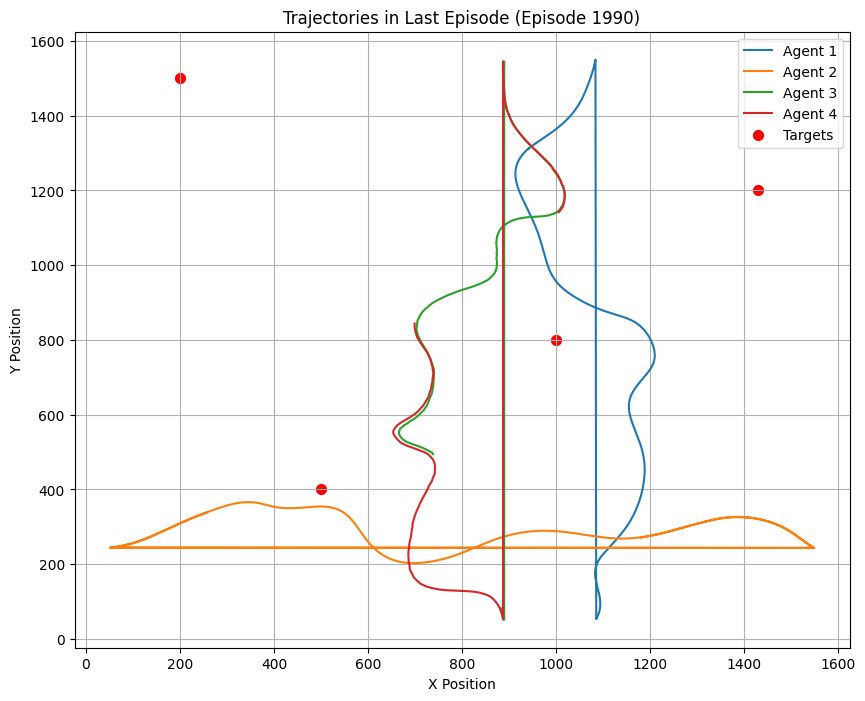

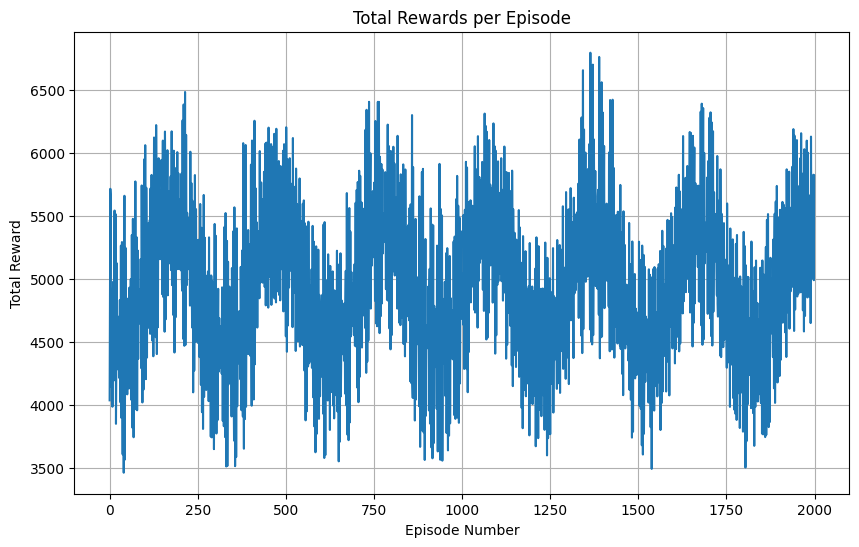

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data
agent_trajectories = np.load('agent_trajectories.npy')  # Shape: (num_agents, max_episodes, steps_per_episode, 2)
episode_rewards = np.load('episode_rewards.npy')  # Shape: (max_episodes,)

num_agents = agent_trajectories.shape[0]
max_episodes = agent_trajectories.shape[1]
Tpos = np.array([[1430, 1200], [1000, 800], [500, 400], [200, 1500]])  # Target positions

# --- Plotting the Trajectories in the Last Episode ---
plt.figure(figsize=(10, 8))
plt.title(f'Trajectories in Last Episode (Episode {max_episodes - 10})')
plt.xlabel('X Position')
plt.ylabel('Y Position')

for agent_id in range(num_agents):
    last_episode_trajectory = agent_trajectories[agent_id, max_episodes - 10]  # Get trajectory from the last episode
    plt.plot(
        last_episode_trajectory[:, 0], last_episode_trajectory[:, 1],
        label=f'Agent {agent_id + 1}'
    )

# Plot target locations
plt.scatter(Tpos[:, 0], Tpos[:, 1], color='red', marker='o', s=50, label='Targets')  # Plot targets

plt.legend()
plt.grid(True)
plt.show()

# --- Plotting Rewards Over Episodes ---
plt.figure(figsize=(10, 6))
plt.plot(episode_rewards)
plt.title('Total Rewards per Episode')
plt.xlabel('Episode Number')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()